# imports

In [1]:
import networkx as nx


import pandas as pd

import json

from pathlib import Path

import seaborn as sns

import matplotlib.pyplot as plt

from collections import Counter

import numpy as np

/home/paul/miniforge3/envs/matos/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# data

In [2]:
data = pd.read_csv("21-multi-europarl.csv",index_col="Unnamed: 0")

In [3]:
len(data)

37799

In [6]:
data = data.dropna(subset=["EU Party", "EU Committee","NationalParty"])

In [7]:
len(data)

36865

## load

In [3]:
root = Path("/path/to/linkedep")
sentences = {}
for path in root.glob("*_sentences.json"):
    lang = path.name.split("_")[0]
    with open(path, "rt") as file:
        sentences[lang] = json.load(file)

In [12]:
s_counter = Counter()
for lang, speeches in sentences.items():
    for speech, speech_sentences in speeches.items():
        s_counter[lang]+=len(speech_sentences)
    

In [5]:
len(sentences.keys())

21

# bi-parallel alignment

## load

In [6]:

bials = {}
for path in root.glob("*_alignments.json"):
    lang = path.name.split("_")[0]
    with open(path, "rt") as file:
        bials[lang] = json.load(file)
print(bials.keys())

dict_keys(['pt', 'lt', 'da', 'fi', 'sk', 'cs', 'el', 'et', 'sl', 'nl', 'es', 'hu', 'lv', 'de', 'fr', 'ro', 'sv', 'pl', 'it', 'bg'])


In [26]:
scores = {}

for path in root.glob("*scores.json"):
    lang = path.name.split("_")[0]
    with open(path, "rt") as file:
        scores[lang] = json.load(file)
print(scores.keys())

dict_keys(['de', 'it', 'es', 'nl', 'el', 'fi', 'sv', 'sl', 'et', 'fr', 'da', 'lt', 'cs', 'hu', 'bg', 'ro', 'sk', 'pt', 'pl', 'lv'])


In [71]:
flat_scores = {}
for lang, lang_score in scores.items():
    lang_flat_score = []
    for k, score in lang_score.items():
        lang_flat_score.extend(score)
    flat_scores[lang] = lang_flat_score

/home/paul/miniforge3/envs/matos/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/paul/miniforge3/envs/matos/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/paul/miniforge3/envs/matos/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/paul/minif

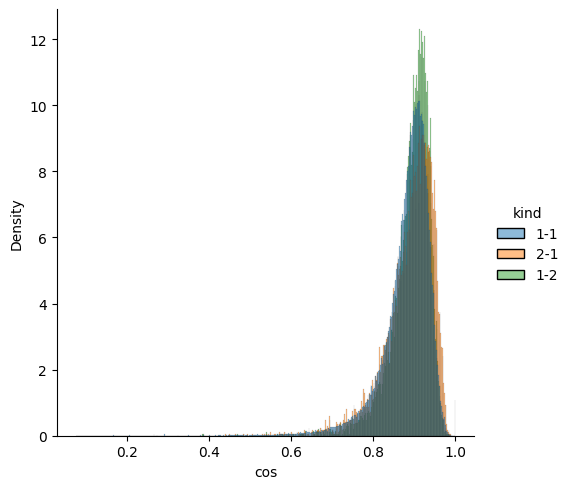

In [70]:
lang_flat_score = pd.DataFrame(flat_scores["fr"])
sns.displot(lang_flat_score[lang_flat_score["kind"].isin({"1-1","1-2","2-1"})],hue="kind", x="cos",stat="density",common_norm=False)

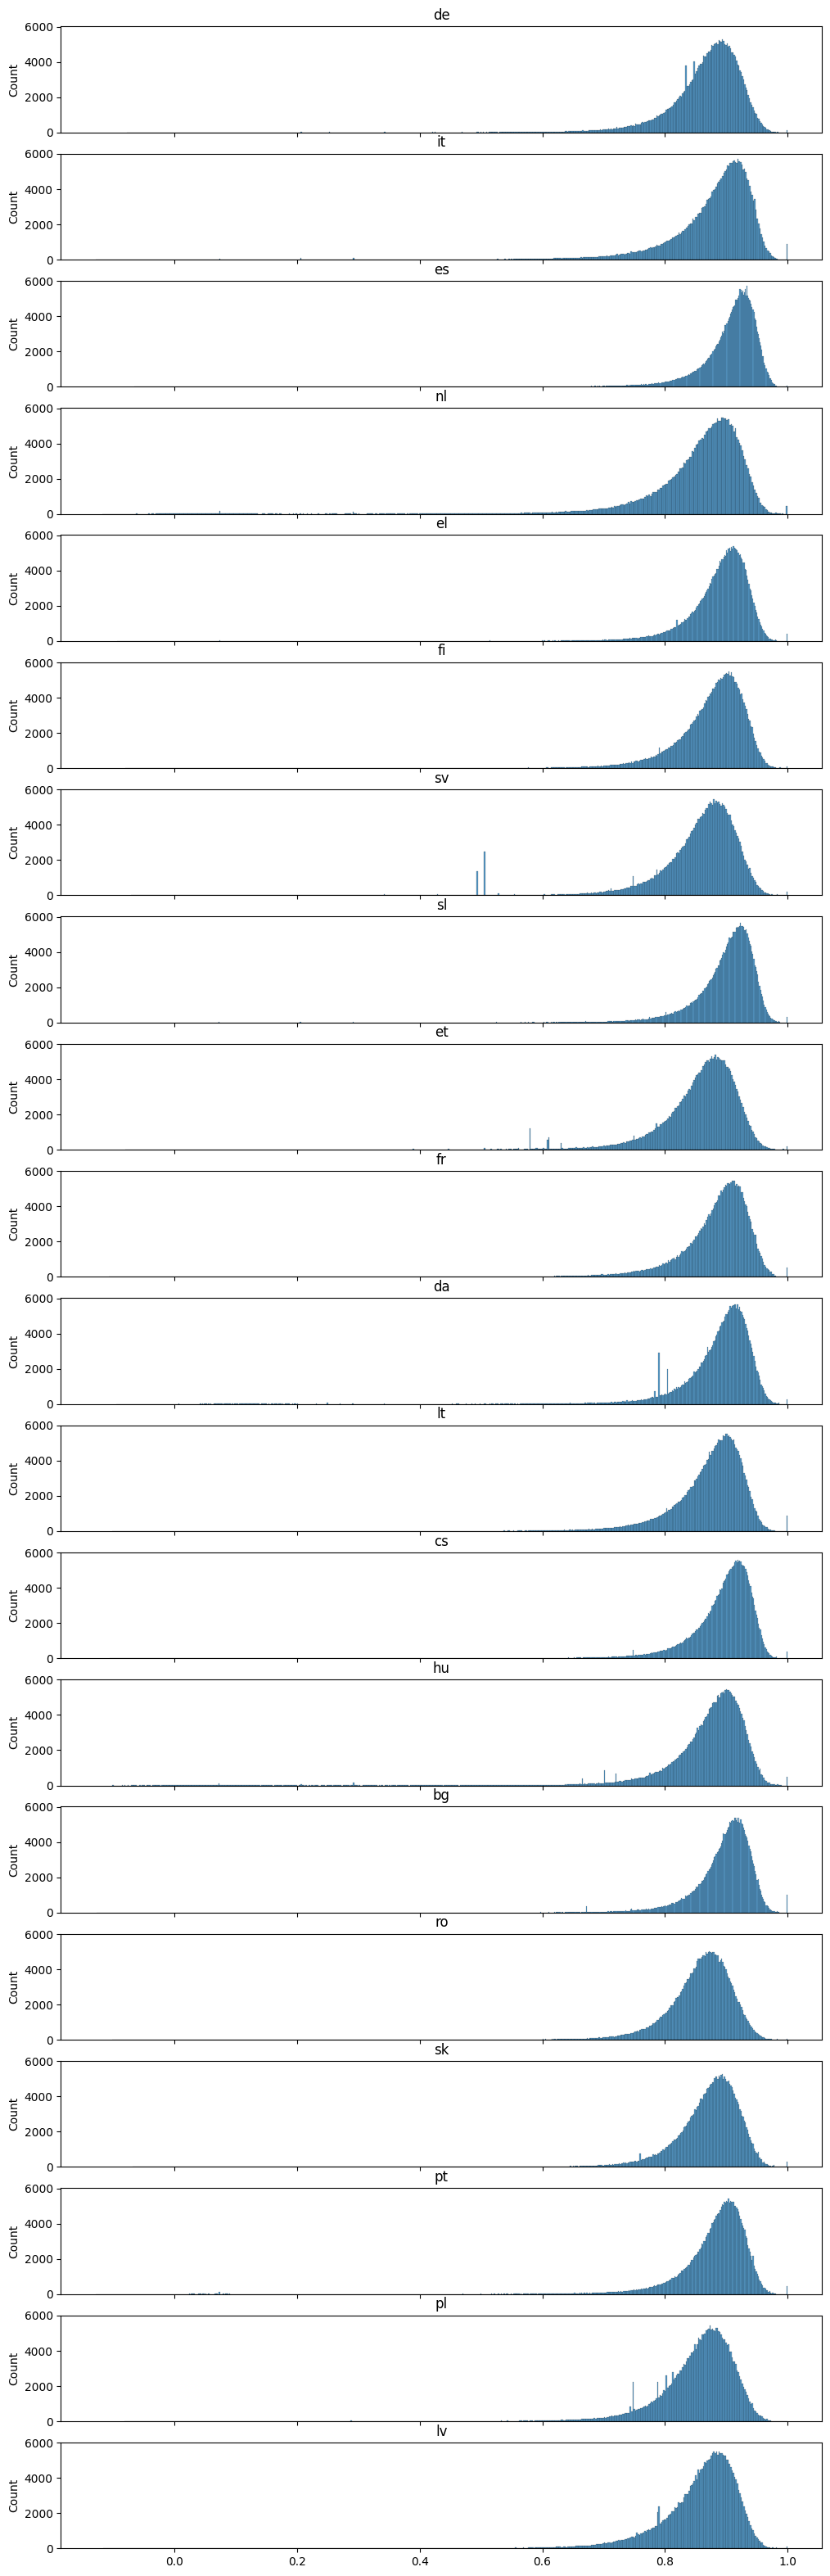

In [88]:
fig,axes = plt.subplots(len(flat_scores),1,figsize=(12,40), sharex=True, sharey=True)#,squeeze=False)
for i, (lang, lang_flat_score) in enumerate(flat_scores.items()):
    sns.histplot(lang_flat_score,ax=axes[i],label=lang)
    axes[i].set_title(lang)

# multi-parallel alignments

In [153]:
src_lang="en"
all_multi_alignments = {}
all_multi_scores= {}
for speech in sentences[src_lang].keys():
    G = nx.Graph()
    for tgt_lang, bial in bials.items():
        for i, (src_range, tgt_range) in enumerate(zip(bial[speech]["src"], bial[speech]["tgt"])):
            score = scores[tgt_lang][speech][i]
            for src_i in src_range:
                for tgt_i in tgt_range:
                    G.add_node((src_lang,src_i))
                    G.add_node((tgt_lang, tgt_i))
                    G.add_edge((src_lang,src_i),(tgt_lang, tgt_i),score=score)

    multi_as, multi_scores = get_multi_alignment(G, sentences.keys())
    all_multi_alignments[speech] = multi_as
    all_multi_scores[speech] = multi_scores

In [148]:
def get_multi_alignment(G, languages):
    multi_as = {tgt_lang: [] for tgt_lang in languages}
    multi_scores = []
    for component in nx.connected_components(G):
        multi_a = {tgt_lang: [] for tgt_lang in languages}
        for lang, index in component:
            multi_a[lang].append(index)
        for lang, indices in multi_as.items():
            multi_as[lang].append(multi_a[lang])
    
        # keep minimum score as multi-parallel score
        score = float("inf")
        for u,v,attr in G.edges(component, data=True):
            if attr["score"] < score:
                score = attr["score"]
        multi_scores.append(score)
    return multi_as, multi_scores

In [157]:
with open(root/"multi-alignments.json","wt") as file:
    json.dump(all_multi_alignments, file)

In [158]:
with open(root/"multi-scores.json","wt") as file:
    json.dump(all_multi_scores, file)

## join data

In [79]:
metadata = set(c for c in data.columns if len(c)!=2)

In [80]:
metadata

{'EU Committee',
 'EU Party',
 'NationalParty',
 'date',
 'speaker',
 'split',
 'src_lang',
 'year'}

In [93]:
sentence_data = []
for key, row in data.iterrows():
    for i, score in enumerate(all_multi_scores[key]):
        if score < 0.8:
            continue
        sentence_row = {"speech": key}
        ok = True
        for lang in all_multi_alignments[key].keys():
            sent_range = all_multi_alignments[key][lang][i]
            # beware sent_range is not sorted (ok because we keep only 1-1 alignments)
            if len(sent_range) != 1:
                ok = False
                break
            j = sent_range[0] #for j in sent_range
            sentence_row[lang] = sentences[lang][key][j]
        if not ok:
            continue
        for field in metadata:
            sentence_row[field] = row[field]
        sentence_data.append(sentence_row)
                

In [95]:
sentence_data=pd.DataFrame(sentence_data)

In [101]:
sentence_data.to_csv(root/"21-multi-europarl-sent-1-1-8.csv")

In [99]:
print(pd.DataFrame([Counter(sentence_data["split"])]).to_markdown(index=False))

|   train |   dev |   test |
|--------:|------:|-------:|
|   22436 | 27603 |  23647 |


In [96]:
sentence_data.columns

Index(['speech', 'sv', 'fr', 'da', 'lt', 'fi', 'nl', 'en', 'hu', 'sl', 'ro',
       'pl', 'pt', 'sk', 'lv', 'de', 'es', 'el', 'cs', 'et', 'it', 'bg',
       'NationalParty', 'year', 'EU Party', 'EU Committee', 'src_lang', 'date',
       'split', 'speaker'],
      dtype='object')

## viz

In [161]:
flat_scores = []
for s in all_multi_scores.values():
    flat_scores.extend(s)

In [165]:
np.quantile(flat_scores,np.arange(0,1.1,0.1))

array([-0.06690387,  0.64880791,  0.71525812,  0.75066015,  0.77569759,
        0.79582661,  0.8131696 ,  0.82979336,  0.84670687,  0.86718711,
        1.00000012])

In [166]:
len(flat_scores)

259076

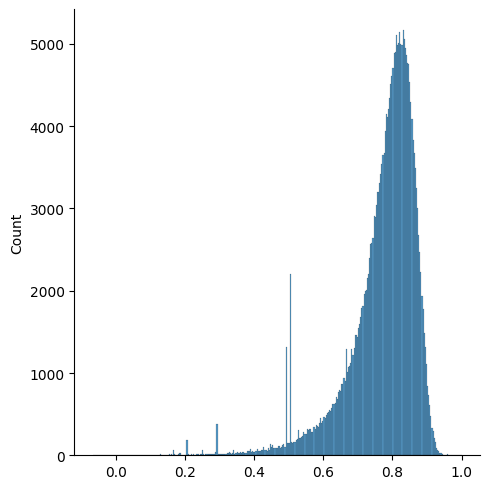

In [162]:
sns.displot(flat_scores)